# test_15
This test circuit has no unknown current sources. 

empty matrices: B, C, D, J, Ev, 


This circuit has 

```
Net list report
number of lines in netlist: 6
number of branches: 6
number of nodes: 3
number of unknown currents: 0
number of RLC (passive components): 5
number of inductors: 0
number of independent voltage sources: 0
number of independent current sources: 1
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0
```


<img src="test_15.png" width="900">  

```
* test_15.asc
I1 1 0 1
R1 1 0 10
R2 2 1 10
R3 3 2 1000
C1 2 0 0.01
C2 3 0 0.002


```



This netlist is read into the Symbolic Modified Nodal Analysis Jupyter notebook and the following circuit equations were generated.  

$v_{1} \cdot \left(\frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{2}}{R_{2}} = - I_{1}$  
$v_{2} \left(C_{1} s + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) - \frac{v_{3}}{R_{3}} - \frac{v_{1}}{R_{2}} = 0$  
$v_{3} \left(C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{2}}{R_{3}} = 0$  




In [1]:
import os
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

Copy the text strings generated by the Symbolic Modified Nodal Analysis Jupyter notebook to the cell below. used in nodal analysis

In [53]:
v1, C2, R2, I1, C1, R3, v2, v3, R1, s = symbols(' v1  C2  R2  I1  C1  R3  v2  v3  R1  s ')
A = Matrix([[1/R2 + 1/R1, -1/R2, 0], [-1/R2, C1*s + 1/R3 + 1/R2, -1/R3], [0, -1/R3, C2*s + 1/R3]])
X = Matrix( [v1, v2, v3] )
Z = Matrix( [-I1, 0, 0] )

equ = Eq(A*X,Z)
equ

⎡         ⎛1    1 ⎞   v₂      ⎤        
⎢      v₁⋅⎜── + ──⎟ - ──      ⎥        
⎢         ⎝R₂   R₁⎠   R₂      ⎥        
⎢                             ⎥   ⎡-I₁⎤
⎢   ⎛       1    1 ⎞   v₃   v₁⎥   ⎢   ⎥
⎢v₂⋅⎜C₁⋅s + ── + ──⎟ - ── - ──⎥ = ⎢ 0 ⎥
⎢   ⎝       R₃   R₂⎠   R₃   R₂⎥   ⎢   ⎥
⎢                             ⎥   ⎣ 0 ⎦
⎢        ⎛       1 ⎞   v₂     ⎥        
⎢     v₃⋅⎜C₂⋅s + ──⎟ - ──     ⎥        
⎣        ⎝       R₃⎠   R₃     ⎦        

## Symbolic solution

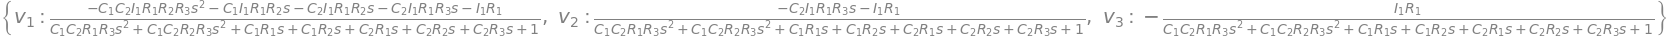

In [54]:
symbolic_solution = solve(equ,X)
symbolic_solution

## Numeric solution

In [55]:
# enter the element values, set I2=0
equ1a = equ.subs({
I1:1.0000e+00,
R1:1.0000e+01,
R2:1.0000e+01,
R3:1.0000e+03,
C1:1.0000e-02,
C2:2.0000e-03
})    

equ1a  # display the equations

⎡            0.2⋅v₁ - 0.1⋅v₂             ⎤   ⎡-1.0⎤
⎢                                        ⎥   ⎢    ⎥
⎢-0.1⋅v₁ + v₂⋅(0.01⋅s + 0.101) - 0.001⋅v₃⎥ = ⎢ 0  ⎥
⎢                                        ⎥   ⎢    ⎥
⎣    -0.001⋅v₂ + v₃⋅(0.002⋅s + 0.001)    ⎦   ⎣ 0  ⎦

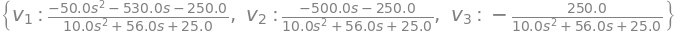

In [56]:
u1 = solve(equ1a,X)
u1

## AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.

In [57]:
1/(2*np.pi)

In [58]:
equ1a_1rad_per_s = equ1a.subs({s:1j})
equ1a_1rad_per_s  # display the equations

⎡            0.2⋅v₁ - 0.1⋅v₂             ⎤   ⎡-1.0⎤
⎢                                        ⎥   ⎢    ⎥
⎢-0.1⋅v₁ + v₂⋅(0.101 + 0.01⋅ⅈ) - 0.001⋅v₃⎥ = ⎢ 0  ⎥
⎢                                        ⎥   ⎢    ⎥
⎣    -0.001⋅v₂ + v₃⋅(0.001 + 0.002⋅ⅈ)    ⎦   ⎣ 0  ⎦

In [59]:
ans1 = solve(equ1a_1rad_per_s,X)
ans1

In [60]:
for name, value in ans1.items():
    print('{:5s}: mag: {:10.6f} phase: {:11.5f} deg'.format(str(name),float(abs(value)),float(arg(value)*180/np.pi)))

v1   : mag:   9.771261 phase:   174.32065 deg
v2   : mag:   9.642525 phase:   168.43003 deg
v3   : mag:   4.312268 phase:   104.99508 deg


The following results were obtained from LTSpice.  
```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:    9.77126 phase:    174.321° 	voltage
V(2):	mag:    9.64252 phase:     168.43° 	voltage
V(3):	mag:    4.31227 phase:    104.995° 	voltage
I(C1):	mag:  0.0964252 phase:    -101.57° 	device_current
I(C2):	mag: 0.00862454 phase:   -165.005° 	device_current
I(I1):	mag:          1 phase:          0° 	device_current
I(R1):	mag:   0.977126 phase:    174.321° 	device_current
I(R2):	mag:   0.100579 phase:    74.0313° 	device_current
I(R3):	mag: 0.00862454 phase:    14.9951° 	device_current
```
The LTSpice results are the same.

## AC Sweep
Looking at node 5 voltage and comparing the results with those obtained from LTSpice. Thr frequency sweep is from 0.01 Hz to 1 Hz.

Load the csv file of node 5 voltage over the sweep range and plot along with the results obtained from SymPy.

In [61]:
os.chdir('/home/jeff32/Documents/Solving Electrical Engineering Problems with Python Blog/MNA Test Circuits/test_15/') # change directory to net list location

fn = 'test_15.csv' # data from LTSpice
#LTSpice_data = np.loadtxt(fn, delimiter='\t',skiprows=1)
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

# change the working director back to the Jupyter folder
os.chdir('/home/jeff32/Documents/JupyterLab/Node Analysis/')  

In [62]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
V_1 = np.zeros(len(LTSpice_data)).astype(complex)
V_2 = np.zeros(len(LTSpice_data)).astype(complex)
V_3 = np.zeros(len(LTSpice_data)).astype(complex)

In [63]:
# convert the csv data to complex numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    V_1[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j
    V_2[i] = LTSpice_data[i][3] + LTSpice_data[i][4]*1j
    V_3[i] = LTSpice_data[i][5] + LTSpice_data[i][6]*1j

Load the Laplace polyinominal for node 5

In [64]:
H = u1[v3]
H

In [65]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_v3 = (a, b) # system for circuit 1

In [66]:
#x = np.linspace(0.01*2*np.pi, 1*2*np.pi, 10000, endpoint=True)
x = np.logspace(-2, 2, 400, endpoint=False)*2*np.pi
w, mag_v3, phase_v3 = signal.bode(system_v3, w=x) # returns: rad/s, mag in dB, phase in deg

Plot the results.

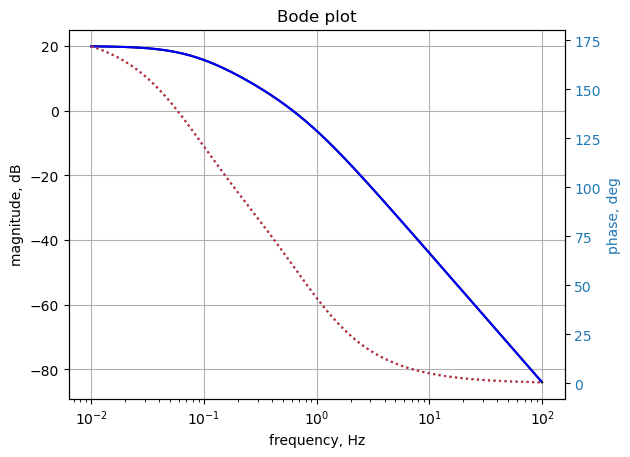

In [67]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(V_3)),'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag_v3,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency, np.angle(V_3)*180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase_v3,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

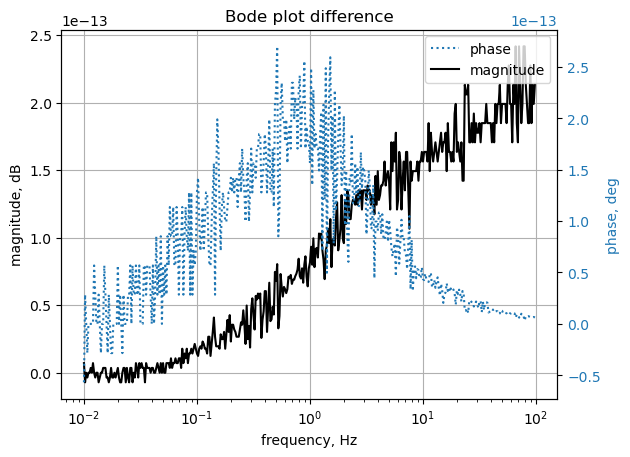

In [68]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], 20*np.log10(np.abs(V_3[0:-1]))-mag_v3,'-k')    # Bode magnitude plot
#plt.semilogx(w/(2*np.pi), mag_v3,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.angle(V_3[0:-1])*180/np.pi-phase_v3,':',color=color,label='phase')  # Bode phase plot
#plt.semilogx(w/(2*np.pi), phase_v3,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='magnitude')

plt.legend()
plt.title('Bode plot difference')
plt.show()

The SymPy and LTSpice results overlay each other. 